In [1]:
# Importing Essential Libraries
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

In [10]:
# Loading the dataset
#unrotated data
train_data1 = sio.loadmat(r"C:\Users\Souvik Bhattacharyya\Desktop\Mentorship\Data\MNIST\mnist_training_data.mat")
train_label1 = sio.loadmat(r"C:\Users\Souvik Bhattacharyya\Desktop\Mentorship\Data\MNIST\mnist_training_label.mat")
test_data1 = sio.loadmat(r"C:\Users\Souvik Bhattacharyya\Desktop\Mentorship\Data\MNIST\mnist_test_data.mat")
test_label1 = sio.loadmat(r"C:\Users\Souvik Bhattacharyya\Desktop\Mentorship\Data\MNIST\mnist_test_label.mat")
#rotated data
train_data2 = sio.loadmat(r"C:\Users\Souvik Bhattacharyya\Desktop\Mentorship\Data\MNIST\emnist_rot\mnist-rot_training_data.mat")
train_label2 = sio.loadmat(r"C:\Users\Souvik Bhattacharyya\Desktop\Mentorship\Data\MNIST\emnist_rot\mnist-rot_training_label.mat")
test_data2 = sio.loadmat(r"C:\Users\Souvik Bhattacharyya\Desktop\Mentorship\Data\MNIST\emnist_rot\mnist-rot_test_data.mat")
test_label2 = sio.loadmat(r"C:\Users\Souvik Bhattacharyya\Desktop\Mentorship\Data\MNIST\emnist_rot\mnist-rot_test_label.mat")


#### We have to process the rotated dataset appropriately so that the two datasets are on the same scale.

In [11]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()

# Unrotated Data
train_data1 = np.array(train_data1["training_data"])
train_data1 = mms.fit_transform(train_data1)
test_data1 = np.array(test_data1["test_data"])
test_data1 = mms.fit_transform(test_data1)

# Rotated Data
train_data2 = np.array(train_data2["train_data"]).reshape(12000, 784)      # reshaping 
train_data2 = mms.fit_transform(train_data2)
test_data2 = np.array(test_data2["test_data"]).reshape(10000, 784)         # reshaping 
test_data2 = mms.fit_transform(test_data2)

In [12]:
x_train = np.append(train_data1, train_data2, axis= 0)        # merged train data
x_test = np.append(test_data1, test_data2, axis= 0)           # merged test data

train_label1 = np.array(train_label1["training_label"])
train_label2 = np.array(train_label2["train_label"]).T
y_train = np.append(train_label1, train_label2, axis = 0)     # merged train label

test_label1 = np.array(test_label1["test_label"])
test_label2 = np.array(test_label2["test_label"]).T
y_test = np.append(test_label1, test_label2, axis = 0)        # merged test label

#### Below is a plot of a random sample from the merged dataset.

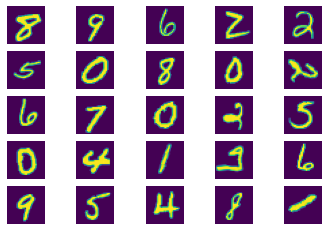

In [17]:
index = np.random.permutation(x_train.shape[0])
k = 1
for i in range(25):
    plt.subplot(5, 5, k)
    plt.imshow(np.array(x_train[index[i], :]).reshape(28, 28))
    plt.axis("off")
    k += 1

# Decision Trees on the original dataset

#### At first we will apply decision tree alogorithm on the unrotated dataset and ckeck that model accuracy on the rotated dataset. Then we will merge the two dataset together and train a model on the new merged datasset and compare the test accuracy on both models. 

In [18]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(train_data1, train_label1)

from sklearn.metrics import accuracy_score
y_pred_tree1 = clf.predict(test_data1)
y_pred_tree2 = clf.predict(test_data2)

print(f"Accuracy of the original test data: {accuracy_score(np.ravel(test_label1), y_pred_tree1) * 100} % ")
print(f"Accuracy of the new rotated test data: {accuracy_score(np.ravel(test_label2), y_pred_tree1) * 100} % ")

Accuracy of the original test data: 87.92999999999999 % 
Accuracy of the new rotated test data: 10.26 % 


#### Though our model performs well on the original test dataset but it fails miserably on the rotated test data.
#### Now we will check if applying random forest on the original data makes any difference in classifying the rotated test data.

In [19]:
from sklearn.ensemble import RandomForestClassifier
clf_random = RandomForestClassifier(random_state=0)
clf_random.fit(train_data1, np.ravel(train_label1))

y_pred_tree1 = clf_random.predict(test_data1)
y_pred_tree2 = clf_random.predict(test_data2)

print(f"Accuracy of the original test data: {accuracy_score(np.ravel(test_label1), y_pred_tree1) * 100} % ")
print(f"Accuracy of the new rotated test data: {accuracy_score(np.ravel(test_label2), y_pred_tree1) * 100} % ")

Accuracy of the original test data: 96.87 % 
Accuracy of the new rotated test data: 10.42 % 


#### So, random forest could not make any difference in the rotated test data though it performed exceptionally well on the original test data.

# Decision Trees on merged dataset

In [20]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)

from sklearn.metrics import accuracy_score
y_pred_tree = clf.predict(x_test)
print(clf.tree_.max_depth)
print(f"Accuracy: {accuracy_score(np.ravel(y_test), y_pred_tree) * 100} % ")

42
Accuracy: 68.89 % 


#### As we can see, after traing the model on the merged dataset, our model did somewhat better compared to the model tested on only the unrotated dataset.

#### Now we are applying decision tree with cost complexity pruning considering alpha values ranging from 0 to 0.0005 with an interval of 0.00005.

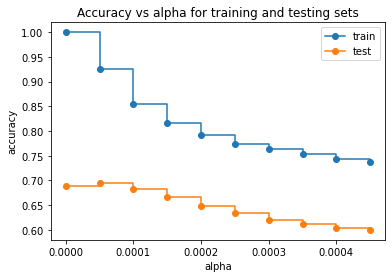

In [21]:
# Cost Coplexity Pruning
from sklearn import tree
import matplotlib.pyplot as plt

ccp_alphas =np.arange(0, 0.0005, 0.00005)
train_scores = []
test_scores = []

for i in np.arange(0, 0.0005, 0.00005):
    clf_pruning = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=i)
    clf_pruning.fit(x_train, y_train)
    train_scores.append(clf_pruning.score(x_train, y_train)) 
    test_scores.append(clf_pruning.score(x_test, y_test)) 
    
# Plotting accuracies vs alpha for training and testing sets    
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [23]:
max_test_score = max(test_scores)
max_at = test_scores.index(max_test_score) * 0.00005
print(f"Max test score of {max(test_scores) * 100}% is obtained when alpha = {format(max_at, '.5f')}")
print(f"Traing score at alpha = {format(max_at, '.5f')} is {train_scores[test_scores.index(max_test_score)] * 100}%")

Max test score of 69.42% is obtained when alpha = 0.00005
Traing score at alpha = 0.00005 is 92.46612903225807%


#### As we can see even after cost complexity pruning the test accuracy remains almost same for the merged dataset.

### Random Forest

#### We applied random forest on the orginal dataset keeping the bagging parameter(number of features to consider when looking for the best split) as default, i.e. $\sqrt p$ where we have $p$ features (in our case, $p = 784$).

In [24]:
# Random Forest
clf_random = RandomForestClassifier(random_state=0)
clf_random.fit(x_train, np.ravel(y_train))
y_pred_random = clf_random.predict(x_test)

print(f"Training accuracy: {clf_random.score(x_train, np.ravel(y_train)) * 100} %")
print(f"Test accuracy: {clf_random.score(x_test, y_test) * 100} %")

Training accuracy: 100.0 %
Test accuracy: 87.58500000000001 %


#### After applying random forest on the merged dataset, it performs quite well on the test data compared to the other methods.